tmp_community: 
{'13': ['13', '4', '8', '3', '14', '18', '2', '20', '1', '12', '22'], '34': ['34', '15', '16', '19', '10', '31', '9', '33', '21', '23', '27', '30'], '17': ['17', '6', '7', '11', '5'], '28': ['28', '24', '25', '26', '32', '29']}
community_node_in_dict: 
{'2': '13', '1': '13', '3': '13', '4': '13', '5': '17', '6': '17', '7': '17', '8': '13', '9': '34', '10': '34', '11': '17', '12': '13', '13': '13', '14': '13', '17': '17', '18': '13', '20': '13', '22': '13', '26': '28', '24': '28', '25': '28', '28': '28', '29': '28', '30': '34', '27': '34', '31': '34', '32': '28', '33': '34', '15': '34', '16': '34', '19': '34', '21': '34', '23': '34', '34': '34'}


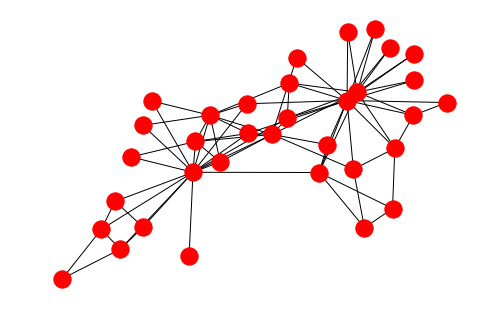

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import networkx as nx
import time
import pdb


def calculateQ(IN, TOT, m):
    '''calculate the modularity'''
    Q = IN/m-((TOT/(2*m))**2)
    return Q



def phases_one(G):
    ##用来存社区编号和其节点（这里的节点为list。所以该dict存储一个社区下包含的所有节点）
    community_dict={}
    ##用来存节点所对应的社区编号
    community_node_in_dict={}
    ##用来保存边两头节点所在社区
    edge_dict={}
    ##存Tot和In (param in modularity gain formula)
    Tot={}  # 储存每个点所连的
    In={}  # 储存每个点

    ##初始化上述指标
    for node in G.nodes():  # get all nodes
        community_dict[node]=[node]  # init: every node list in a community numbered by itself
        community_node_in_dict[node]=node  # init: every node in a community numbered by itself
        #初始化Tot
        T=0.  # init T as float 0.
        for nbrs in G.neighbors(node): 
            #############
#             print(G.get_edge_data(nbrs, node).values())
#             pdb.set_trace()
            #############
            if node==nbrs:
                T += (2 * int(list(G.get_edge_data(nbrs,node).values())[0]))
            else:
                T+= int(list(G.get_edge_data(nbrs,node).values())[0])
        Tot[node]=T
        #初始化In
        if G.get_edge_data(node,node)==None:
            In[node]=0.
        else:
            In[node]= int(list(G.get_edge_data(node,node).values())[0])

    #初始化M
    M=0.0
    for edge in G.edges():
        M+= int(list(G.get_edge_data(*edge).values())[0])
        edge_dict[(edge[0],edge[1])]=(community_node_in_dict[edge[0]],community_node_in_dict[edge[1]])
    index=True
    ##一直遍历直到收敛
    while index==True:
        index=False
        ##遍历所有节点
        for node in G.nodes():
            ##保存节点之前所在社区
            old_community=community_node_in_dict[node]
            # 用来保存节点node的总权值
            ki = 0
            # 保存其所有邻居社区
            nbrs_community={}
            # 保存该节点移动到某社区所带来的In增益
            kiin_dict={}
            # 保存其离开自己所在社区的的In减少量
            kiout=0.
            # 目标社区
            max_community=-1
            max_detaQ=-1
            max_nbrs=-1
            # 临时保存edge_dict变化
            edge_dict_tmp={}
            for nbrs in G.neighbors(node):
                weight= int(list(G.get_edge_data(node,nbrs).values())[0])
                if nbrs==node:
                    ki+=(2*weight)
                else:
                    ki+=weight
                current_community=community_node_in_dict[nbrs]
                if current_community==old_community:
                    kiout+=weight
                    continue

#                 if nbrs_community.has_key(current_community):
                if current_community in nbrs_community.keys():
                    kiin_dict[current_community]+=weight
                else :
                    nbrs_community[current_community]=current_community
                    kiin_dict[current_community]=weight
                    if G.has_edge(node, node):
                        kiin_dict[current_community] += int(list(G.get_edge_data(node, node).values())[0])
            #计算它离开自己社区的detaQ
            detaQ1=calculateQ(In[old_community]-kiout,Tot[old_community]-ki,M)-calculateQ(In[old_community],Tot[old_community],M)
            #计算将要加入的社区的detaQ
            for com in nbrs_community:
                detaQ2=calculateQ(In[com]+kiin_dict[com],Tot[com]+ki,M)-calculateQ(In[com],Tot[com],M)
                Q=detaQ2+detaQ1
                if Q>max_detaQ and Q>0:
                    max_detaQ=Q
                    max_community=com
                    max_nbrs=nbrs
            #如果该社区使网络模块度增加，则加进去
            if max_detaQ>0:
                index=True
                #更新节点社区编号
                community_node_in_dict[node]=max_community
                #更新所去的社区的In和Tot值
                In[max_community]=In[max_community] + kiin_dict[max_community]
                Tot[max_community]=Tot[max_community]+ki
                #更新原先的社区值
                In[old_community]=In[old_community]-kiout
                Tot[old_community]=Tot[old_community]-ki
                #更新社区
                community_dict[max_community].append(node)
                community_dict[old_community].remove(node)
                #原社区没有节点了就删除
                if community_dict[old_community].__len__()==0:
                    community_dict.__delitem__(old_community)
                    In.__delitem__(old_community)
                    Tot.__delitem__(old_community)
                #更新edge
#                 if edge_dict.has_key((node,max_nbrs)):
                if (node,max_nbrs) in edge_dict.keys():
                    edge_dict[(node,max_nbrs)]=(max_community,max_community)
                else:
                    edge_dict[(max_nbrs, node)] = (max_community, max_community)

    nowQ = 0
    for com in community_dict:
        nowQ+=calculateQ(In[com], Tot[com] , M)
    return G,community_node_in_dict,community_dict,nowQ,Tot,In



def phase_two(now_G,community_node_dict):
    super_G=nx.Graph()
    super_edge={}
    for edge in now_G.edges():
        super_node1=community_node_dict[edge[0]]
        super_node2=community_node_dict[edge[1]]
        if (super_node1,super_node2) in super_edge or (super_node2,super_node1) in super_edge:
            if super_node1!=super_node2:
                super_edge[(super_node1,super_node2)]+= int(list(now_G.get_edge_data(*edge).values())[0])
                super_edge[(super_node2, super_node1)] += int(list(now_G.get_edge_data(*edge).values())[0])
            else:
                super_edge[(super_node1, super_node1)] += int(list(now_G.get_edge_data(*edge).values())[0])
        else:
            super_edge[(super_node1, super_node2)] = int(list(now_G.get_edge_data(*edge).values())[0])
            super_edge[(super_node2, super_node1)] = int(list(now_G.get_edge_data(*edge).values())[0])

    for edge in super_edge:
        if super_G.has_edge(*edge):
            continue
        super_G.add_edge(*edge,weight=super_edge[edge])
    for node in now_G.nodes():
        if now_G.degree(node)==0:
            super_G.add_node(node)
    return super_G

def merge_community_node(next_community, tmp_community, community_node_in_dict):
    communitys = {}
    for i in next_community.keys():
        communitys[i] = []
        for node in next_community[i]:
            for n in tmp_community[node]:
                community_node_in_dict[n]=i
                communitys[i].append(n)
    return communitys


def BGLL(G):
    ##进行第一次迭代
    # t1 = time.clock()
    now_G, community_node_dict, now_community, now_Q, now_Tot, now_In = phases_one(G)
    community_node_in_dict = community_node_dict
    # print "迭代第一次时间：", time.clock() - t1
    # print "社区总数：", now_community.__len__()
    tmp_community = now_community
    # print "Q:", now_Q, '\n'
    times = 1
    while True:
        times += 1
        ##根据now_edge_dict形成超级节点图
        t2 = time.clock()
        super_G = phase_two(now_G, community_node_dict)
        # print "第", times, "个图生成的时间:", time.clock() - t2
        ##用超级节点形成的图去迭代
        t2 = time.clock()
        now_G, community_node_dict, now_community, next_Q, next_Tot, next_In = phases_one(super_G)
        # print "迭代第", times, "次的时间：", time.clock() - t2
        # print "社区总数：", now_community.__len__()
        ##如果当前社区的nextQ没有增加就返回
        # print "Q:", next_Q, '\n'
        if next_Q <= now_Q:
            break
        now_Q = next_Q
        now_Tot, now_In = next_Tot, next_In
        tmp_community = merge_community_node(now_community, tmp_community, community_node_in_dict)
    return tmp_community,community_node_in_dict

# t3=time.clock()
# G = constrauct_graph()
# BGLL(G)
# print "总时间：",time.clock()-t3


def construct_graph(graph_file):
    G = nx.Graph()
    with open(graph_file, 'r') as f:
        fr = f.read()
        lines = fr.split('\n')
        for line in lines:
#             print(line)
            try:
                node_from = (line.split(' ')[0]).strip()
                node_end = (line.split(' ')[1]).strip()
                weight = (line.split(' ')[2]).strip()
                G.add_weighted_edges_from([(node_from, node_end, weight)])
            except IndexError as e:
                break
    nx.draw(G)
    return G


if __name__ == '__main__':
#     graph_file = 'C:/Wang Hanmo/study/data_set/graph_data/zachary_karate.txt'
    graph_file = 'C:/Wang Hanmo/study/data_set/graph_data/undirected/unweighted/karate/karate_test_weighted.txt'
    G = construct_graph(graph_file)
    tmp_community,community_node_in_dict = BGLL(G)
    print('tmp_community: ')
    print(tmp_community)
    print('community_node_in_dict: ')
    print(community_node_in_dict)











2 1 1
3 1 1
3 2 1
4 1 1
4 2 1
4 3 1
5 1 1
6 1 1
7 1 1
7 5 1
7 6 1
8 1 1
8 2 1
8 3 1
8 4 1
9 1 1
9 3 1
10 3 1
11 1 1
11 5 1
11 6 1
12 1 1
13 1 1
13 4 1
14 1 1
14 2 1
14 3 1
14 4 1
17 6 1
17 7 1
18 1 1
18 2 1
20 1 1
20 2 1
22 1 1
22 2 1
26 24 1
26 25 1
28 3 1
28 24 1
28 25 1
29 3 1
30 24 1
30 27 1
31 2 1
31 9 1
32 1 1
32 25 1
32 26 1
32 29 1
33 3 1
33 9 1
33 15 1
33 16 1
33 19 1
33 21 1
33 23 1
33 24 1
33 30 1
33 31 1
33 32 1
34 9 1
34 10 1
34 14 1
34 15 1
34 16 1
34 19 1
34 20 1
34 21 1
34 23 1
34 24 1
34 27 1
34 28 1
34 29 1
34 30 1
34 31 1
34 32 1
34 33 1


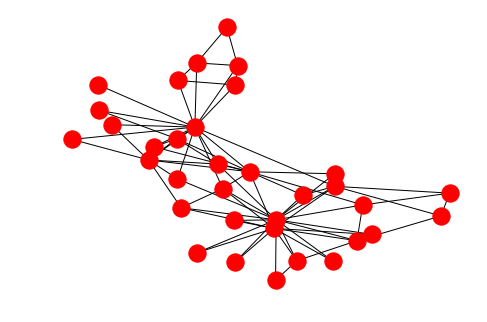

In [10]:
# construct the graph

def construct_graph(graph_file):
    G = nx.Graph()
    with open(graph_file, 'r') as f:
        fr = f.read()
        lines = fr.split('\n')
        for line in lines:
            print(line)
            try:
                node_from = (line.split(' ')[0]).strip()
                node_end = (line.split(' ')[1]).strip()
                weight = (line.split(' ')[2]).strip()
                G.add_weighted_edges_from([(node_from, node_end, weight)])
            except IndexError as e:
                break
    nx.draw(G)
    return G

if __name__ == '__main__':
#     graph_file = 'C:/Wang Hanmo/study/data_set/graph_data/zachary_karate.txt'
    graph_file = 'C:/Wang Hanmo/study/data_set/graph_data/undirected/unweighted/karate/karate_test_weighted.txt'
    G = construct_graph(graph_file)